# Data Loading

## Load Dataset

### Cifar10

In [28]:
from tensorflow.keras import datasets

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [29]:
input_shape = train_images.shape[1:]
classes = 10
num_samples = train_images.shape[0]

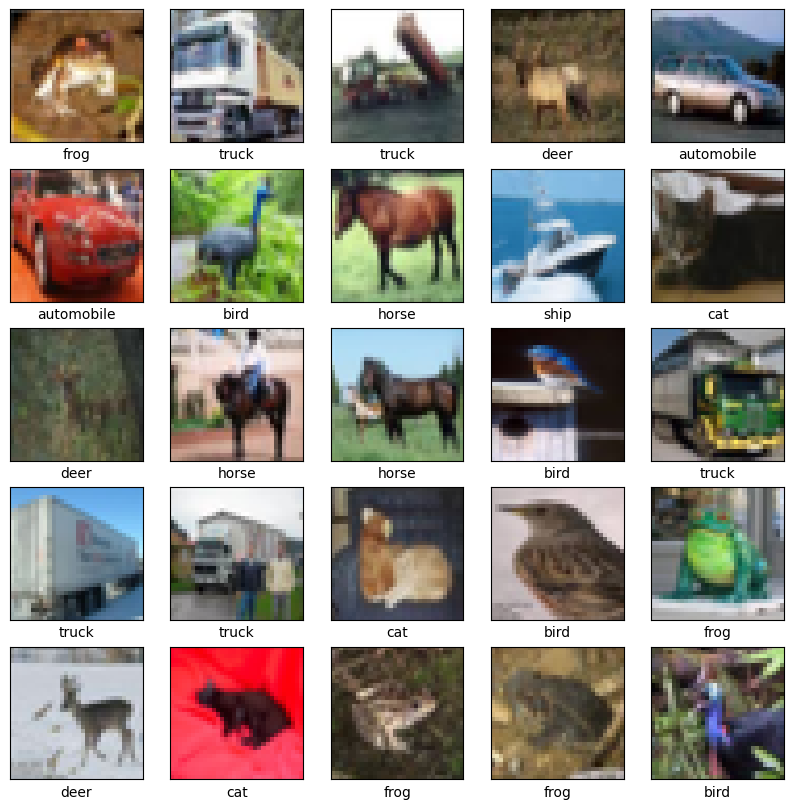

In [30]:
import matplotlib.pyplot as plt
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### NIH CXR Dataset

In [31]:
# import pandas as pd

# nih_label_csv = pd.read_csv("D:/Work_archived/WIL-Onboard/NIH_dataset/Data_Entry_2017.csv")
# nih_label = pd.DataFrame()
# nih_label['Image Index'] = nih_label_csv['Image Index']
# nih_label['Finding Labels'] = nih_label_csv['Finding Labels']

In [32]:
# nih_label['one_hot'] = None
# display(nih_label)

In [33]:
# nih_class = ["Atelectasis", "Cardiomegaly","Effusion","Infiltration","Mass","Nodule","Pneumonia","Pneumothorax","Consolidation","Edema","Emphysema","Fibrosis","Pleural_Thickening","Hernia"]
# zero_onehot = [0 for j in range(len(nih_class))]
# for idx,i in enumerate(nih_label['Finding Labels']):
#     onehot = zero_onehot.copy()
#     if i == 'No Finding':
#         nih_label['one_hot'].iloc[idx] = zero_onehot
#     else:
#         list_l = i.split('|')
#         for j in list_l:
#             onehot[nih_class.index(j)] = 1
#         nih_label['one_hot'].iloc[idx] = onehot
    

In [34]:
# display(nih_label)

In [35]:
# data_label = nih_label['one_hot'].to_list()

In [36]:
# import os
# nih_path = "D:/Work_archived/WIL-Onboard/NIH_dataset"
# list_image_dir=[]
# for path in os.scandir(nih_path):
#     if path.is_dir():
#         list_image_dir.append(path.name)
# for i,j in enumerate(list_image_dir):
#     list_image_dir[i] = nih_path + "/" + j 

In [37]:
# list_image_dir

In [38]:
# import tensorflow as tf
# import fnmatch
# batch_size = 64
# img_h = 256
# img_w = 256
# random_seed = 7
# dataset_nih_list = []
# start_idx = 0
# end_idx = 0
# for idx, dir in enumerate(list_image_dir):
#     count = len(fnmatch.filter(os.listdir(dir+"/images"), '*.png'))
#     end_idx = start_idx + count
#     dataset_nih_list.append(tf.keras.utils.image_dataset_from_directory(directory=dir,
#                                                 labels = data_label[start_idx:end_idx],
#                                                 label_mode = 'int',
#                                                 color_mode = 'grayscale',
#                                                 batch_size = batch_size,
#                                                 image_size = (img_h,img_w),
#                                                 seed = random_seed
#                                                 ))
#     start_idx += count

In [39]:
# dataset = dataset_nih_list[0]
# for i in range(1,len(dataset_nih_list)):
#     dataset = dataset.concatenate(dataset_nih_list[i])

In [40]:
# import numpy as np
# x= np.array(None)
# for i,j in dataset.as_numpy_iterator():
#     x = np.append(x,i)

In [41]:
# tf.keras.utils.image_dataset_from_directory(
#     directory,
#     labels='inferred',
#     label_mode='int',
#     class_names=None,
#     color_mode='rgb',
#     batch_size=32,
#     image_size=(256, 256),
#     shuffle=True,
#     seed=None,
#     validation_split=None,
#     subset=None,
#     interpolation='bilinear',
#     follow_links=False,
#     crop_to_aspect_ratio=False,
#     **kwargs
# )

## Create Noisy label

### define function

In [42]:
from numpy.testing import assert_array_almost_equal
import numpy as np
def multiclass_noisify(y, P, random_state=0):
    """ Flip classes according to transition probability matrix T.
    It expects a number between 0 and the number of classes - 1.
    """
    ## check size of label and prob matrix
    print (np.max(y), P.shape[0])
    assert P.shape[0] == P.shape[1]
    assert np.max(y) < P.shape[0]

    # row stochastic matrix
    assert_array_almost_equal(P.sum(axis=1), np.ones(P.shape[1]))
    assert (P >= 0.0).all()

    ## create new label
    m = y.shape[0]
    print (m)
    new_y = y.copy()
    ## create Randomstate object
    flipper = np.random.RandomState(random_state)

    for idx in np.arange(m):
        i = y[idx]
        # draw a vector with only an 1
        flipped = flipper.multinomial(1, P[i, :][0], 1)[0]
        # print(flipped)
        new_y[idx] = np.where(flipped == 1)[0]

    return new_y

In [43]:
def noisify_pairflip(y_train, noise, random_state=None, nb_classes=10):
    """mistakes:
        flip in the pair
    """
    P = np.eye(nb_classes)
    ## noise rate
    n = noise

    if n > 0.0:
        # 0 -> 1
        P[0, 0], P[0, 1] = 1. - n, n
        for i in range(1, nb_classes-1):
            P[i, i], P[i, i + 1] = 1. - n, n
        P[nb_classes-1, nb_classes-1], P[nb_classes-1, 0] = 1. - n, n

        y_train_noisy = multiclass_noisify(y_train, P=P,
                                           random_state=random_state)
        actual_noise = (y_train_noisy != y_train).mean()
        assert actual_noise > 0.0
        print('Actual noise %.2f' % actual_noise)
        y_train = y_train_noisy
    print (P)

    return y_train,actual_noise

In [44]:
def noisify_multiclass_symmetric(y_train, noise, random_state=None, nb_classes=10):
    """mistakes:
        flip in the symmetric way
    """
    P = np.ones((nb_classes, nb_classes))
    n = noise
    P = (n / (nb_classes - 1)) * P

    if n > 0.0:
        # 0 -> 1
        P[0, 0] = 1. - n
        for i in range(1, nb_classes-1):
            P[i, i] = 1. - n
        P[nb_classes-1, nb_classes-1] = 1. - n

        y_train_noisy = multiclass_noisify(y_train, P=P,
                                           random_state=random_state)
        actual_noise = (y_train_noisy != y_train).mean()
        assert actual_noise > 0.0
        print('Actual noise %.2f' % actual_noise)
        y_train = y_train_noisy
    print(P)

    return y_train, actual_noise

### pair flip create noise

In [45]:
new_label_train_pair,actual_noise_rate = noisify_pairflip(train_labels, 0.2, random_state=7, nb_classes=10)
noise_or_not = (new_label_train_pair==train_labels)

9 10
50000
Actual noise 0.20
[[0.8 0.2 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.8 0.2 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.8 0.2 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.8 0.2 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.8 0.2 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.8 0.2 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.8 0.2 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.8 0.2 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.2]
 [0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.8]]


### uniform create noise

In [46]:
new_label_train_sym,actual_noise_rate = noisify_multiclass_symmetric(train_labels, 0.2, random_state=7, nb_classes=10)

9 10
50000
Actual noise 0.20
[[0.8        0.02222222 0.02222222 0.02222222 0.02222222 0.02222222
  0.02222222 0.02222222 0.02222222 0.02222222]
 [0.02222222 0.8        0.02222222 0.02222222 0.02222222 0.02222222
  0.02222222 0.02222222 0.02222222 0.02222222]
 [0.02222222 0.02222222 0.8        0.02222222 0.02222222 0.02222222
  0.02222222 0.02222222 0.02222222 0.02222222]
 [0.02222222 0.02222222 0.02222222 0.8        0.02222222 0.02222222
  0.02222222 0.02222222 0.02222222 0.02222222]
 [0.02222222 0.02222222 0.02222222 0.02222222 0.8        0.02222222
  0.02222222 0.02222222 0.02222222 0.02222222]
 [0.02222222 0.02222222 0.02222222 0.02222222 0.02222222 0.8
  0.02222222 0.02222222 0.02222222 0.02222222]
 [0.02222222 0.02222222 0.02222222 0.02222222 0.02222222 0.02222222
  0.8        0.02222222 0.02222222 0.02222222]
 [0.02222222 0.02222222 0.02222222 0.02222222 0.02222222 0.02222222
  0.02222222 0.8        0.02222222 0.02222222]
 [0.02222222 0.02222222 0.02222222 0.02222222 0.02222222 0

## Image Augmentation

In [47]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        # layers.Rescaling(1.0 / 255),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomCrop(input_shape[0],input_shape[1])

    ]
)

## Create data pipeline

In [48]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

shuffle_buffer = 1024
batch_size = 256

# train_labels = keras.utils.to_categorical(train_labels, num_classes = classes)

noise_or_not = (train_labels==new_label_train_sym)

## one-hot label
new_label_train_sym  = keras.utils.to_categorical(new_label_train_sym, num_classes = classes)
test_labels  = keras.utils.to_categorical(test_labels, num_classes = classes)

# rescale image from 0-255 to 0-1
train_images_scaled = train_images/255
test_images_scaled = test_images/255

# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
# train_dataset = train_dataset.shuffle(buffer_size=shuffle_buffer).batch(batch_size).map(lambda x, y: (data_augmentation(x), y))


noisy_train_dataset = tf.data.Dataset.from_tensor_slices((train_images_scaled, new_label_train_sym))
# noisy_train_dataset = noisy_train_dataset.shuffle(buffer_size=shuffle_buffer).batch(batch_size).map(lambda x, y: (data_augmentation(x), y))
noisy_train_dataset = noisy_train_dataset.batch(batch_size).map(lambda x, y: (data_augmentation(x), y))

val_dataset = tf.data.Dataset.from_tensor_slices((test_images_scaled, test_labels))
val_dataset = val_dataset.batch(batch_size)


# Model Building

## ResNet Model

In [49]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Rescaling, Input
resnet = ResNet101(include_top=False,weights=None,input_shape=input_shape,classes=classes,pooling='avg')

out = tf.keras.layers.Dense(classes,activation='softmax')(resnet.output)
res_model = tf.keras.models.Model(inputs=resnet.input, outputs=out)

inp = Input(input_shape)
scaled_inp = Rescaling(1./255)(inp)
otp = res_model(scaled_inp)

model = tf.keras.models.Model(inputs= inp, outputs=otp)
model.summary()
res_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 32, 32, 3)         0         
_________________________________________________________________
model (Functional)           (None, 10)                42678666  
Total params: 42,678,666
Trainable params: 42,573,322
Non-trainable params: 105,344
_________________________________________________________________
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
___________________________________________________________

In [50]:
# from tensorflow.keras.applications import ResNet101
# from tensorflow.keras.layers import Rescaling, Input
# input_shape = (256,256,1)
# classes = 14
# resnet = ResNet101(include_top=False,weights=None,input_shape=input_shape,classes=classes,pooling='avg')

# out = tf.keras.layers.Dense(classes,activation='sigmoid')(resnet.output)
# res_model = tf.keras.models.Model(inputs=resnet.input, outputs=out)

# inp = Input(input_shape)
# scaled_inp = Rescaling(1./255)(inp)
# otp = res_model(scaled_inp)

# model = tf.keras.models.Model(inputs= inp, outputs=otp)
# model.summary()
# res_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 256, 256, 1)       0         
_________________________________________________________________
model_2 (Functional)         (None, 14)                42680590  
Total params: 42,680,590
Trainable params: 42,575,246
Non-trainable params: 105,344
_________________________________________________________________
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 1) 0                                            
_________________________________________________________

# Main

## define function

In [51]:
def average_top_loss(loss_array):
    # ind_1_sorted = np.argsort(loss_array)
    # loss = loss_array[ind_1_sorted].copy()
    loss = loss_array[::-1]
    top_0_20 = np.array(loss[:(len(loss)*20)//100])
    # top_10_20 = np.array(loss[(len(loss)*10)//100:(len(loss)*20)//100])
    top_20_40 = np.array(loss[(len(loss)*20)//100:(len(loss)*40)//100])
    top_40_60 = np.array(loss[(len(loss)*40)//100:(len(loss)*60)//100])
    top_60_100 = np.array(loss[(len(loss)*60)//100:])
    # return [top_0_20.mean(),top_10_20.mean(),top_20_40.mean(),top_40_60.mean(),top_60_100.mean()]
    return [top_0_20.mean(),top_20_40.mean(),top_40_60.mean(),top_60_100.mean()]

In [52]:
import matplotlib.pyplot as plt
def plot_loss_graph(all_loss,r1=0.01,r2=0.001,c=10):
    x = [[].copy() for i in range(len(all_loss[0]))]
    x_lr = []
    y = range(1,1+len(all_loss))
    fig, ax = plt.subplots(2,1)
    for j in range(len(all_loss)):
        t = (j % c) / float((c)-1)
        lr = (1 - t) * r1 + t * r2
        x_lr.append(lr)
        for i in range(len(all_loss[0])):
            x[i].append(float(all_loss[j][i]))

    text_label = ["top0-20%","top20-40%", "top40-60%", "top60_100%"]

    ax[0].plot(y,x_lr,label= "lr")
    for i in range(len(all_loss[0])):
        ax[1].plot(y,x[i],label = text_label[i])
    
    fig.set_figheight(10)
    fig.set_figwidth(15)
    ax[0].set_ylabel('Learning Rate')
    ax[1].set_ylabel('Training Loss')
    ax[1].set_xlabel('Epoch')
    fig.suptitle('Loss Average in Training Loop')
    ax[1].legend()
    fig.align_labels()
    plt.show()


In [53]:
import json
def save_json(var,path):
    jsonStr = json.dumps(var)
    jsonFile = open(path +".json", "w")
    jsonFile.write(jsonStr)
    jsonFile.close()

def load_json(path):
    fileObject = open(path +".json", "r")
    jsonContent = fileObject.read()
    var = json.loads(jsonContent)
    return var

## First Stage

In [16]:
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.losses = []

    def on_epoch_end(self, epoch, logs=None):
        print('loss : ', logs['loss'])
        
        self.losses.append(logs['loss'])
        

def first_stage(model,train_dataset,val_dataset,max_epoch=5,load_weight = False,savepath = './save/f1_checkpoint',loadpath = './save/f1_checkpoint'):
    savepath = savepath

    all_sample_loss = []

    if load_weight:
        model.load_weights(loadpath)

    optimizer = keras.optimizers.SGD(
                    learning_rate=0.01,
                    momentum=0.9,
                    decay = 5e-4
                )
    history = LossHistory()
    loss_fn = keras.losses.CategoricalCrossentropy(reduction="auto")
    loss_fn_none = keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)


    model.compile(optimizer=optimizer, loss=loss_fn,metrics=['categorical_accuracy'])

    example_loss = np.zeros(num_samples)

    for epoch in range(max_epoch):
        
        indexes =0

        print("epoch : ", epoch)
        
        model.fit(x=train_dataset,epochs=1,verbose=1,validation_data=val_dataset)
        
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            y_pred = model.predict(x_batch_train)
            batch_loss = loss_fn_none(y_batch_train,y_pred)
            for i in batch_loss.numpy():
                example_loss[indexes]=i
                indexes +=1

        all_sample_loss.append(example_loss.tolist().copy())
        save_json(example_loss.tolist().copy(),'./save_loss/loss_f1_'+str(epoch))

        model.save_weights(savepath)

    return all_sample_loss


In [25]:
import tensorflow as tf
from tensorflow import keras
import time

def first_stage(model,train_dataset,val_dataset,epochs=5,load_weight = False,savepath = './save/f1_checkpoint',loadpath = './save/f1_checkpoint'):
    savepath = savepath

    all_sample_loss = []
    
    if load_weight:
        model.load_weights(loadpath)

    optimizer = keras.optimizers.SGD(
                    learning_rate=0.01,
                    momentum=0.9,
                    nesterov=True,
                    decay = 5e-4
                )

    ## SparseCategorical
    # loss_fn = keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
    # train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
    # val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

    ## Normal Categorical (one-hot label)
    loss_fn = keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
    train_acc_metric = keras.metrics.CategoricalAccuracy()
    val_acc_metric = keras.metrics.CategoricalAccuracy()

    # model.compile(optimizer= optimizer,
    #               loss=loss_fn,
    #               metrics= ['categorical_accuracy']
    #               )
    globals_loss = 0
    example_loss = np.zeros(num_samples)
    
    
    for epoch in range(epochs):
        print("\nStart Epoch : " ,epoch)
        start_time = time.time()
        indexes = 0
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):


            with tf.GradientTape() as tape:

                logits = model(x_batch_train, training=True)

                loss_value = loss_fn(y_batch_train, logits)
            
            for l in loss_value:
                example_loss[indexes] = float(l)
                # print(example_loss[indexes])
                indexes +=1

            globals_loss += loss_value.numpy().sum()

            # loss_value = tf.math.subtract(loss_value, tf.math.reduce_mean(loss_value))
            # loss_mean = tf.math.reduce_sum(loss_value)
            
            grads = tape.gradient(loss_value, model.trainable_weights)

            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            train_acc_metric.update_state(y_batch_train, logits)
            if step%100 == 0:
                model.save_weights(savepath)
            ##
            # break
            
        all_sample_loss.append(average_top_loss(example_loss).copy())
    

        train_acc = train_acc_metric.result()
        print("Training acc over epoch: %.4f" % (float(train_acc),))

        train_acc_metric.reset_states()

        for x_batch_val, y_batch_val in val_dataset:
            val_logits = model(x_batch_val, training=False)
            val_acc_metric.update_state(y_batch_val, val_logits)
            ##
            # break
    
        val_acc = val_acc_metric.result()
        val_acc_metric.reset_states()
        print("Validation acc: %.4f" % (float(val_acc),))
        print("Time taken: %.2fs" % (time.time() - start_time))

    return all_sample_loss

In [19]:
loss_stage1 = first_stage(model,noisy_train_dataset,val_dataset,max_epoch=30,savepath='./save/f1_checkpoint')

epoch :  0
3125/3125 [==============================] - 180s 54ms/step - loss: 3.1181 - categorical_accuracy: 0.1213 - val_loss: 3.5808 - val_categorical_accuracy: 0.1315
epoch :  1
3125/3125 [==============================] - 169s 54ms/step - loss: 2.6033 - categorical_accuracy: 0.1437 - val_loss: 4.0104 - val_categorical_accuracy: 0.1668
epoch :  2
3125/3125 [==============================] - 168s 54ms/step - loss: 2.4475 - categorical_accuracy: 0.1546 - val_loss: 2.7764 - val_categorical_accuracy: 0.1886
epoch :  3
3125/3125 [==============================] - 174s 56ms/step - loss: 2.3382 - categorical_accuracy: 0.1612 - val_loss: 3.0781 - val_categorical_accuracy: 0.1928
epoch :  4
3125/3125 [==============================] - 174s 56ms/step - loss: 2.2861 - categorical_accuracy: 0.1701 - val_loss: 2.4137 - val_categorical_accuracy: 0.1907
epoch :  5
3125/3125 [==============================] - 176s 56ms/step - loss: 2.2540 - categorical_accuracy: 0.1761 - val_loss: 2.5297 - val_cat

In [20]:
save_json(loss_stage1,'./save_loss/loss_f1_data_1')

In [ ]:
import json

aList = [41, 58, 63]
jsonStr = json.dumps(loss_stage1)
print(jsonStr)
jsonFile = open("loss_f1_data.json", "w")
jsonFile.write(jsonStr)
jsonFile.close()

[[2.5520559195280077, 2.3956203859806062, 2.3089787415742875, 2.1567890966326], [2.4837272282361984, 2.369816170287132, 2.307099980187416, 2.188363251078129], [2.44916385371685, 2.3556289673566817, 2.3037091046094895, 2.2100954724669455], [2.4691354429244994, 2.3517788400411606, 2.3031363549232484, 2.1900450683891775], [2.4568198223352433, 2.3494677512168884, 2.3051540804624557, 2.1939007679104807]]


In [7]:
import json
fileObject = open("loss_f1_data.json", "r")
jsonContent = fileObject.read()
loss_stage1 = json.loads(jsonContent)

[[2.5520559195280077, 2.4837272282361984, 2.44916385371685, 2.4691354429244994, 2.4568198223352433], [2.3956203859806062, 2.369816170287132, 2.3556289673566817, 2.3517788400411606, 2.3494677512168884], [2.3089787415742875, 2.307099980187416, 2.3037091046094895, 2.3031363549232484, 2.3051540804624557], [2.1567890966326, 2.188363251078129, 2.2100954724669455, 2.1900450683891775, 2.1939007679104807]]


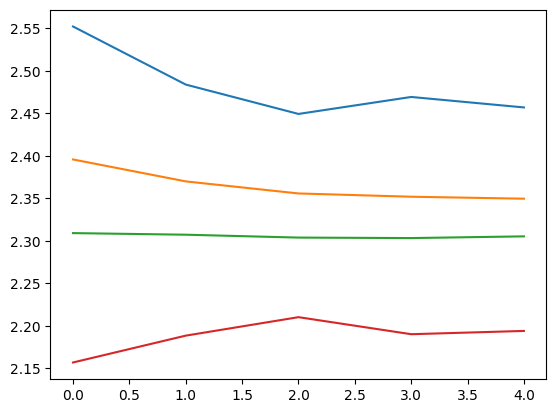

In [8]:
plot_loss_graph(loss_stage1)

## Second Stage

In [136]:
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.losses = []

    def on_epoch_end(self, epoch, logs=None):
        print('loss : ', logs['loss'])
        
        self.losses.append(logs['loss'])
        

def second_stage(model,train_dataset,val_dataset,max_epoch=5,r1=0.01,r2=0.001,cy_loop = 10,forget_rate=0.1):
    savepath = './save/s2_checkpoint'

    all_sample_loss = []
    # all_sample_loss_avg = []

    optimizer = keras.optimizers.SGD(
                    learning_rate=0.01,
                    momentum=0.9,
                    decay = 5e-4
                )
    history = LossHistory()
    loss_fn = keras.losses.CategoricalCrossentropy(reduction="auto")
    loss_fn_none = keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)


    model.compile(optimizer=optimizer, loss=loss_fn,metrics=['categorical_accuracy'])

    # model.fit(x=train_dataset,epochs=epochs,verbose=1, callbacks=[history],
    #                     validation_data=val_dataset)
    # for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
    #     y_pred = model.predict(x_batch_train)
    #     all_sample_loss.append(loss_fn(y_batch_train,y_pred))

    moving_loss_dic = np.zeros(num_samples)
    globals_loss = 0
    example_loss = np.zeros(num_samples)

    for epoch in range(max_epoch):
        
        indexes =0
        t = (epoch % cy_loop) / float((cy_loop)-1)
        lr = (1 - t) * r1 + t * r2

        model.optimizer.learning_rate = lr 
        print("epoch : ", epoch, "lr:%f" % lr)
        
        model.fit(x=train_dataset,epochs=1,verbose=1,validation_data=val_dataset)
        
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            y_pred = model.predict(x_batch_train)
            batch_loss = loss_fn_none(y_batch_train,y_pred)
            for i in batch_loss.numpy():
                example_loss[indexes]=i
                indexes +=1

        
        all_sample_loss.append(example_loss.tolist().copy())
        save_json(example_loss.tolist().copy(),'./save_loss/loss_s2_'+str(epoch))

        example_loss = example_loss - example_loss.mean()
        # all_sample_loss_avg.append(average_top_loss(example_loss).copy())
        moving_loss_dic=moving_loss_dic+example_loss

        ## return indices of sorted array
        ind_1_sorted = np.argsort(moving_loss_dic)
		## sort total by use sorted indices array
        loss_1_sorted = moving_loss_dic[ind_1_sorted]

		## set nth rank to keep
        remember_rate = 1 - forget_rate
        num_remember = int(remember_rate * len(loss_1_sorted))

		## find accuracy of noise detection
        noise_accuracy=np.sum(noise_or_not[ind_1_sorted[num_remember:]]) / float(len(loss_1_sorted)-num_remember)

		## create filter_mask
        mask = np.ones_like(example_loss,dtype=np.float32)
		## set top n% rank to zero (for cleansing noise)
        mask[ind_1_sorted[num_remember:]]=0

		## find top 0.1 noise accuracy
        top_accuracy_rm=int(0.9 * len(loss_1_sorted))
        top_accuracy= 1-np.sum(noise_or_not[ind_1_sorted[top_accuracy_rm:]]) / float(len(loss_1_sorted) - top_accuracy_rm)
        print ( "noise_accuracy:%f"%(1-noise_accuracy),"top 0.1 noise accuracy:%f"%top_accuracy)


        
    return all_sample_loss,mask,ind_1_sorted


In [ ]:
import tensorflow as tf
from tensorflow import keras
import time

def second_stage(model,train_dataset,val_dataset,max_epoch=5):
    savepath = './save/s2_checkpoint'
    forget_rate = 0.1

    all_sample_loss = []

    # if load_weight:
    #     model.load_weights(savepath)

    optimizer = keras.optimizers.SGD(
                    learning_rate=0.01,
                    momentum=0.9,
                    nesterov=True,
                    decay = 5e-4
                )

    loss_fn = keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)

    train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = keras.metrics.SparseCategoricalAccuracy()
    
    moving_loss_dic = np.zeros(num_samples)

    globals_loss = 0
    example_loss = np.zeros(num_samples)
    
    epochs = max_epoch
    
    for epoch in range(epochs):
        print("\nStart Epoch : " ,epoch)
        start_time = time.time()
        indexes = 0

        ## calculate lr in linear equation from 0.0091 to 0.001 and delta == 0.0009
        t = (epoch % 10 + 1) / float(10)
        lr = (1 - t) * 0.1 + t * 0.01

        optimizer.learning_rate = lr 

        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

            with tf.GradientTape() as tape:

                logits = model(x_batch_train, training=True)

                loss_value = loss_fn(y_batch_train, logits)
            
            for l in loss_value:
                example_loss[indexes] = float(l)
                # print(example_loss[indexes])
                indexes +=1

            globals_loss += loss_value.numpy().sum()

            # loss_value = tf.math.subtract(loss_value, tf.math.reduce_mean(loss_value))
            # loss_mean = tf.math.reduce_sum(loss_value)
            
            grads = tape.gradient(loss_value, model.trainable_weights)

            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            train_acc_metric.update_state(y_batch_train, logits)
            if step%100 == 0:
                model.save_weights(savepath)
            ##
            break
        
        all_sample_loss.append(average_top_loss(example_loss).copy())

        example_loss = example_loss - example_loss.mean()
        moving_loss_dic=moving_loss_dic+example_loss

        ## return indices of sorted array
        ind_1_sorted = np.argsort(moving_loss_dic)
		## sort total by use sorted indices array
        loss_1_sorted = moving_loss_dic[ind_1_sorted]

		## set nth rank to keep
        remember_rate = 1 - forget_rate
        num_remember = int(remember_rate * len(loss_1_sorted))

		## find accuracy of noise detection
		# noise_accuracy=np.sum(noise_or_not[ind_1_sorted[num_remember:]]) / float(len(loss_1_sorted)-num_remember)

		## create filter_mask
        mask = np.ones_like(example_loss,dtype=np.float32)
		## set top n% rank to zero (for cleansing noise)
        mask[ind_1_sorted[num_remember:]]=0

		## find top 0.1 noise accuracy
		# top_accuracy_rm=int(0.9 * len(loss_1_sorted))
		# top_accuracy= 1-np.sum(noise_or_not[ind_1_sorted[top_accuracy_rm:]]) / float(len(loss_1_sorted) - top_accuracy_rm)

        

        train_acc = train_acc_metric.result()
        print("Training acc over epoch: %.4f" % (float(train_acc),))

        train_acc_metric.reset_states()

        for x_batch_val, y_batch_val in val_dataset:
            val_logits = model(x_batch_val, training=False)
            val_acc_metric.update_state(y_batch_val, val_logits)
            ##
            break
    
        val_acc = val_acc_metric.result()
        val_acc_metric.reset_states()
        print("Validation acc: %.4f" % (float(val_acc),))
        print("Time taken: %.2fs" % (time.time() - start_time))

    return all_sample_loss,mask

In [18]:
model.load_weights('./save/f1_checkpoint')

In [17]:
loss_stage2, filter_mask,sorted_ind = second_stage(model,noisy_train_dataset,val_dataset,max_epoch=50,r1=0.01,r2=0.001,cy_loop=10)

epoch :  0 lr:0.010000
196/196 [==============================] - 49s 157ms/step - loss: 3.0286 - categorical_accuracy: 0.1752 - val_loss: 20.1873 - val_categorical_accuracy: 0.1161
noise_accuracy:0.226000 top 0.1 noise accuracy:0.226000
epoch :  1 lr:0.009000
196/196 [==============================] - 27s 136ms/step - loss: 2.6491 - categorical_accuracy: 0.2511 - val_loss: 2.3556 - val_categorical_accuracy: 0.2512
noise_accuracy:0.255800 top 0.1 noise accuracy:0.255800
epoch :  2 lr:0.008000
196/196 [==============================] - 27s 137ms/step - loss: 2.4156 - categorical_accuracy: 0.2982 - val_loss: 5.7738 - val_categorical_accuracy: 0.3107
noise_accuracy:0.294000 top 0.1 noise accuracy:0.294000
epoch :  3 lr:0.007000
196/196 [==============================] - 27s 136ms/step - loss: 2.2415 - categorical_accuracy: 0.3225 - val_loss: 3.5195 - val_categorical_accuracy: 0.3289
noise_accuracy:0.330000 top 0.1 noise accuracy:0.330000
epoch :  4 lr:0.006000
196/196 [===================

In [141]:
model.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 256, 256, 1)]     0         
_________________________________________________________________
rescaling_16 (Rescaling)     (None, 256, 256, 1)       0         
_________________________________________________________________
model_17 (Functional)        (None, 14)                42680590  
Total params: 42,680,590
Trainable params: 42,575,246
Non-trainable params: 105,344
_________________________________________________________________


In [ ]:
loss_stage2, filter_mask,sorted_ind = second_stage(model,dataset_nih_list[0],dataset_nih_list[0],max_epoch=50,r1=0.01,r2=0.001,cy_loop=10)

In [19]:
save_json(loss_stage2,"./save_loss/loss_s2_data_13")
save_json(filter_mask.tolist(),"./save_mask/mask_13")
save_json(sorted_ind.tolist(),"./save_ranked_list/ranked_ind_13")

In [56]:
loss_stage2 = np.array(load_json('./save_loss/loss_s2_data_11'))
filter_mask = np.array(load_json("./save_mask/mask_11"))
sorted_ind =  np.array(load_json("./save_ranked_list/ranked_ind_11"))

In [59]:
1-(np.sum(noise_or_not[sorted_ind[int(50000*0.9):]]) /len(noise_or_not[sorted_ind[int(50000*0.9):]]))

0.7054

In [61]:
save_json(noise_or_not.tolist(),"./noise_or_not_Test")

In [55]:
noise_or_not

40004

In [25]:
truemask = noise_or_not.flatten()

In [31]:
ranked_loss = []
for i in loss_stage2:
    ranked_loss.append(i[sorted_ind].tolist().copy())
top_ranked_loss = []
for i in ranked_loss:
    top_ranked_loss.append(average_top_loss(i).copy())

In [21]:
top_ranked_loss = []
for i in loss_stage2:
    top_ranked_loss.append(average_top_loss(i).copy())

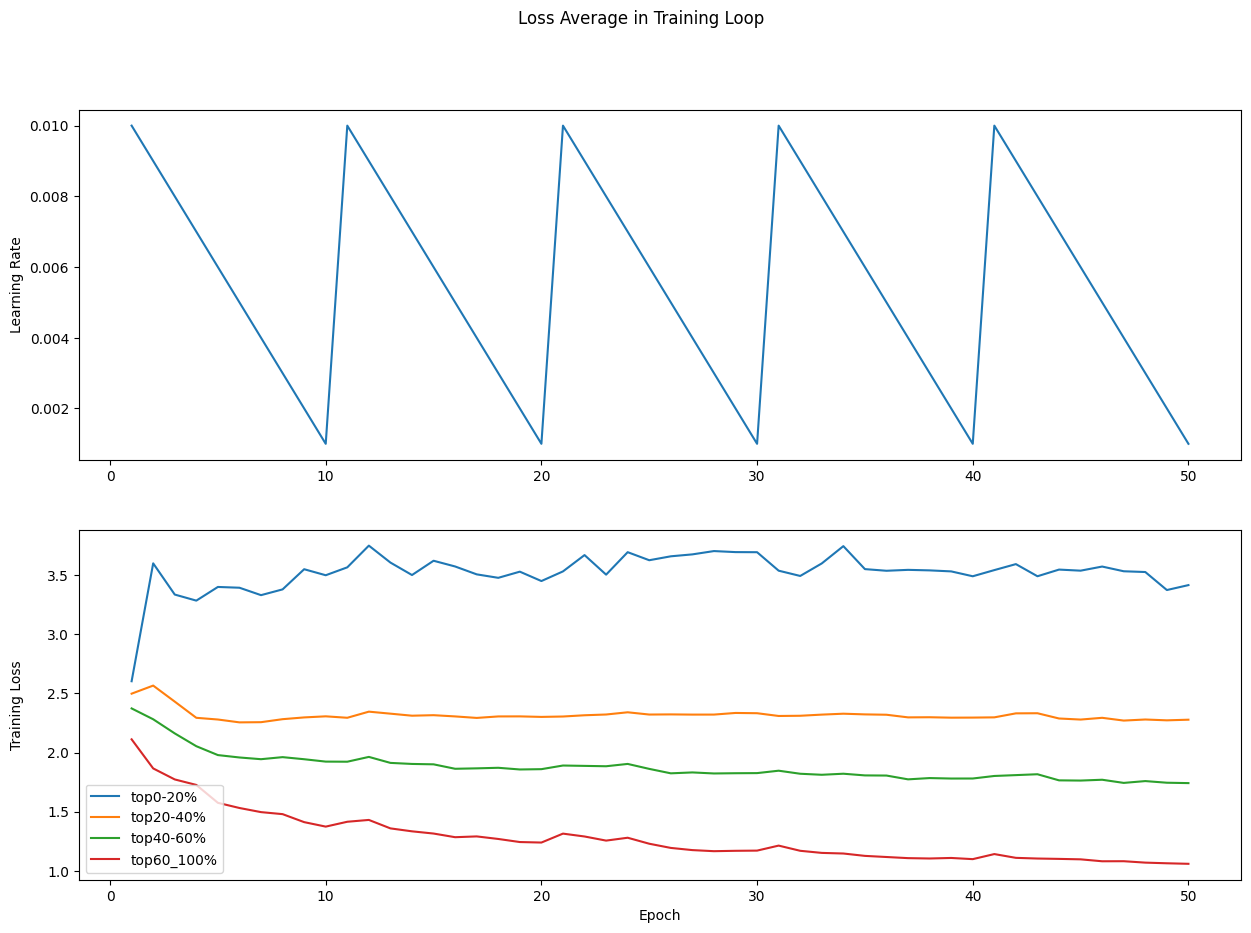

In [32]:
# l2 = np.array(top_ranked_loss)
# l2 = (l2 - l2.min())/(l2.max() - l2.min())
plot_loss_graph(top_ranked_loss,r1=0.01,r2=0.001,c=10)

## Third Stage

In [49]:
filter_mask = filter_mask.astype(bool)
cleansed_train_dataset = tf.data.Dataset.from_tensor_slices((train_images[filter_mask], new_label_train_sym[filter_mask]))
cleansed_train_dataset = cleansed_train_dataset.shuffle(buffer_size=shuffle_buffer).batch(batch_size).map(lambda x, y: (data_augmentation(x), y))

In [ ]:
loss_stage3 = first_stage(model,cleansed_train_dataset,val_dataset,True,savepath = './save/t3_checkpoint',loadpath = './save/f1_checkpoint')